<a href="https://colab.research.google.com/github/Sunkyoung/PyTorch-Study/blob/main/PyTorch_Study_07_CNN(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7: Convolutional Neural Networks

In this practice session, we will cover implementation of Convolutional Neural Networks (CNNs) using PyTorch library. Particulary, in part 1, we will see how to define and use convolutional, batch normalization, and dropout layer to build a simple CNNs to classify MNIST. In part 2, we will implement ResNet for CIFAR-10 classification task and see the effectiveness of residual connection. 

## 0. Preliminary

Let's import required libraries and datasets. We will use MNIST and CIFAR-10 to train a simple CNNs and ResNet, respectively. 

In [1]:
## For sunkyoung!

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image

In [3]:
# MNIST
mnist_train = MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=128, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=128, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=128, shuffle=False)

In case of CIFAR-10, we use conventional transforms and normalization.

In [4]:
transforms_train = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transforms_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_train = CIFAR10(root='./', train=True, 
            download=True, transform=transforms_train)
cifar_test = CIFAR10(root='./', train=False, 
             download=True, transform=transforms_test)
cifar_loader = {}
cifar_loader['train'] = DataLoader(cifar_train, batch_size=128, 
                        shuffle=True, num_workers=4)
cifar_loader['test'] = DataLoader(cifar_test, batch_size=128, 
                       shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 1. Convolutional, Batch Norm and Dropout Layer Practice

### 1.1. Convolutional Layer

In PyTorch, 2-dimensional convolutional layer is given with the pytorch `torch.nn.Conv2d` package. In this section, we will learn basic usage of pytorch convolutional layer with some example codes and practices.

As in our lecture session, we should specify convolution with the number of channels of input and output, kernel size, the size of stride and padding. In Pytorch `torch.nn.Conv2d` class, those traits can be specified as class parameters. The detailed explanation and default values are available on below and the official sites (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)


* in_channels (int) – Number of channels in the input image

* out_channels (int) – Number of channels produced by the convolution

* kernel_size (int or tuple) – Size of the convolving kernel

* stride (int or tuple, optional) – Stride of the convolution. Default: 1

* padding (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0

Now, let's define our convolutional layer and practice. As in our lecture note, let's suppose we have 32x32-sized image with 3 channels. 

In [5]:
"""
Note: Since PyTorch Conv2d receives 4-dimensional input (i.e. a batch of image(s)), 
we define input x with the first argument 1.
"""
x = torch.randn(1, 3, 32, 32)

Then, the number of input channel is 3, which is the same value with the input images' channel (the second argument of above `randn` method). 

How about the number of output channel, kernel and stride size? Following the figure in our lecture note, we can easily see that the number of output channel should be 1. You can naively regard the kernel size as the spatial size of filter in the lecture note. Thus, the kernel size should be (5,5), and the stride size should be 1. In practice, since the spatial size of filter in in square form (i.e., width = height), we usually specifiy kernel size with only single integer (in our case 5).

In [6]:
Image("assets/fig1.png")

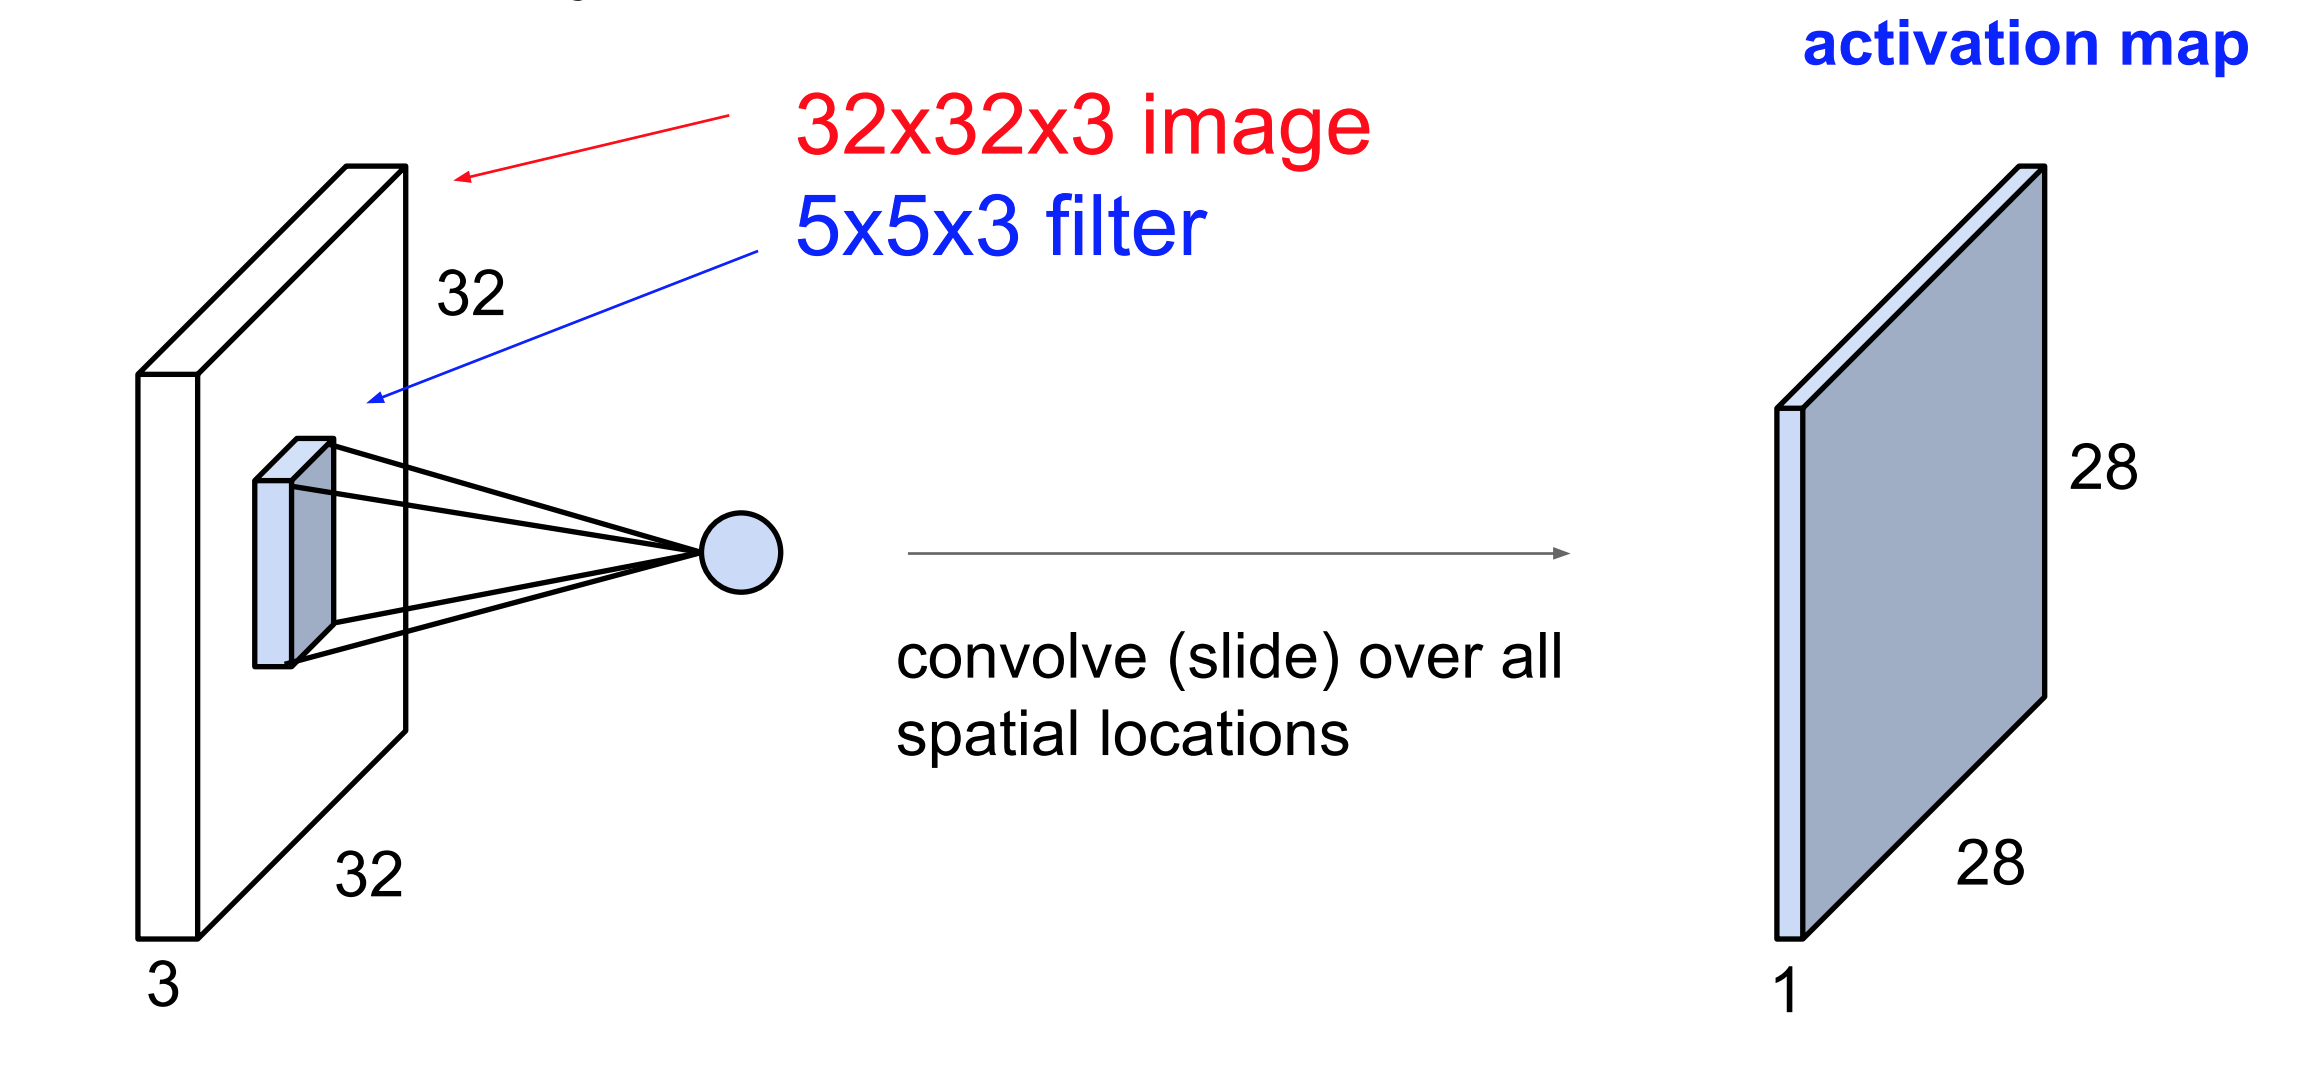

In [7]:
##Q1.Make a conv_layer with torch.nn.Conv2d, according to figure above
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=5, stride=1)

In [8]:
# You should check the output size of covolution layer is [1, 1, 28, 28].
conv_layer(x).size()

torch.Size([1, 1, 28, 28])

Also check the other example in the lecture note as below. 
* Input volume: 3x32x32
* 10 5x5 filters with stride 1, pad 2

In [9]:
##Q2. Make a simple conv_layer & print the output size of the convolution layer 
#2-1)initialize the input image 
#2-2)make a conv_layer
#2-3)print the output size
x = torch.randn(1, 3, 32, 32)
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
print(conv_layer(x).size())

torch.Size([1, 10, 32, 32])


### 1.2. BatchNorm and Dropout layer

In a similar manner, batch normalization and dropout layer also can be used from `torch.nn.BatchNorm2d` and `torch.nn.`.

In [10]:
x = torch.randn(1, 3, 32, 32)

#TIP, num_feature in BatchNorm usually related with the output channel size!
bn = torch.nn.BatchNorm2d(num_features=3)
print(bn(x).size()) # check batch norm does not change the size of input

dropout = torch.nn.Dropout2d(p=0.5) # dropout can specify probability of an element to be zeroed.
print(dropout(bn(x)).size()) # check dropout does not change the size of input

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


### 1.3. Build a Simple Convolutional Neural Network

We can combine convolution layer, batch norm layer and activation function (e.g., ReLU) to construct a functional unit. In this case, we can use `torch.nn.Sequential` to define a block of sequential layers. 

In [11]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #Q3. Make a sequential layer1&layer2 "conv_layer => batch normalization => activation function(Relu)"
        #3-1)conv_layer : input image channel : 1, output channels : 32, filter(square convolution) 7x7, stride : 1 

        self.layer1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, stride=1),
          nn.BatchNorm2d(num_features=32),
          nn.ReLU()
        )
        
        #3-2)conv_layer : input image channel : 32, output channels : 64, filter(square convolution) 7x7, stride : 1 
        self.layer2 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1),
          nn.BatchNorm2d(num_features=64),
          nn.ReLU()
        )

        #make a fully connected layer(linear layer) to classify the mnist data set
        #which has input size = ? , output size = ? 
        self.fc = nn.Linear(64 * 16 * 16, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out



In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

cuda:0


In [13]:
#TIP, this is the classification loss
criterion = torch.nn.CrossEntropyLoss()

In [14]:
for _ in range(20):
    for x, y in dataloaders['train']:
        x, y = x.to(device), y.to(device)
        out = net(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [15]:
net.eval()
correct = 0.0
for x, y in dataloaders['test']:
    x, y = x.to(device), y.to(device)
    out = net(x)
    correct += (out.argmax(1) == y).float().sum().item()
print(100. * correct / len(dataloaders['test'].dataset))

99.01


## 2. CNN Architecture: ResNet

In this section, we will implement ResNet and see the effectiveness of residual connection in terms of test performance.

The overall structure of ResNet is like below.

* input(channel:3) -> (conv 3x3) -> (bn) -> (relu) -> output(channel:16)
* n Residual blocks: (16 channels -> 16 channels)
* n Residual blocks: (16 channels -> 32 channels)
* n Residual blocks: (32 channels -> 64 channels)
* global average pooling + fully connected layer

n can be chosen from {3,5,7,9,18} which of each corresponds to ResNet-20, 32, 44, 56, and 110, respectively.

### 2.1. Residual Block

Residual Block consists of 2 convolution layers with 3x3 size kernel and ReLU activation function (See below figure). Let's implement `ResidualBlock` class below with 2 convolutional layers and residual connection.

In [16]:
Image("assets/fig2.png", width=300)

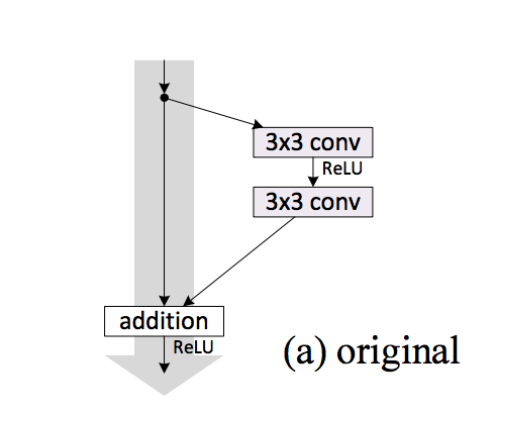

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(ResidualBlock, self).__init__()

        ## Q4. Implement the residual block with 2 conv layers 
        #4-1) fill out the first layer & implement second conv layer " conv -> batch norm ", activation is done after added with the original block

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.down_sample = down_sample
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        
    def down_sampling(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.out_channels - self.in_channels))
        out = nn.MaxPool2d(1, stride=self.stride)(out)
        return out
        

    def forward(self, x):
        #TIP, short cut(x) will be used to build residual connection.
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        ##4-2) implement the shortcut using down_sampling method
        if self.down_sample:
          shortcut = self.down_sampling(x)

        out += shortcut # residual connection
        out = self.relu(out)
        return out

`ResidualBlock` class which extends `torch.nn.Module`. `ResidualBlock` class receives `in_channels`, `out_channels`, `stride` and `down_sample`. 

In ResNet, there are residual blocks that twice the output channel(16 to 32, 32 to 64). The `stride` argument for `ResidualBlock` is set to 2 in such residual blocks to down sample (reduce spatial dimension) while increasing channels.

However, the residual connection in the residual block can occur dimension mismatch since the output of other path (through convolutional layers) change the dimension of input with `stride=2`. Thus, residual block should support downsample through the residual connection in demand. 

We support this feature in `down_sampling` method in `ResidualBlock` class. It conducts zero-padding to exapnd the channels and max-pooling to shrink spatial dimension through residual block. Using `down_sampling` in the middle of the `forward` method to handle `down_sample` condition to residual connection.

### 2.2. ResNet

Now implement `ResNet` class. Assume the `block` argument will be `ResidualBlock` we implemented above. Here are required implementation details.

* In `init` method, specifiy all details of convolution, batch norm layers. 
* In `get_layers` method, set down_sample boolean variable according to the stride information. Then, define a list of residual blocks (`layer_list`). Make sure the down-sample only occurs at the first block in demand.

In [39]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, num_classes=10):
        super(ResNet, self).__init__()
        self.num_layers = num_layers
        
        ##Q5. Implement the conv & batch norm & activation layers
        #5-1) specifics : input(channel:3) -> (conv 3x3) -> (bn) -> (relu) -> output(channel:16)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        #5-2) set down_sample boolean variable according to the stride information.
        # feature map size = 16x32x32
        self.layers_2n = self.get_layers(block, 16, 16, stride=1)
        # feature map size = 32x16x16
        self.layers_4n = self.get_layers(block, 16, 32, stride=2)
        # feature map size = 64x8x8
        self.layers_6n = self.get_layers(block, 32, 64, stride=2)
        
        # output layers
        self.avg_pool = nn.AvgPool2d(8, stride=1)
        self.fc_out = nn.Linear(64, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    ##5-3) Implement the get_layers : this function makes that the down sample only occurs at the first block when it is needed.
    # layer_list : list that had the information of the resifual blocks. 1) define the blocks 2) append the each blocks  
    def get_layers(self, block, in_channels, out_channels, stride):
        if stride == 2:
            down_sample = True
        else:
            down_sample = False
            
        ## 1) define the layer_list 2) append the each blocks
        layer_list = nn.ModuleList([block(in_channels, out_channels, stride, down_sample)])
        for _ in range(self.num_layers - 1):
            layer_list.append(block(out_channels, out_channels))
            
        return nn.Sequential(*layer_list)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers_2n(x)
        x = self.layers_4n(x)
        x = self.layers_6n(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_out(x)
        
        return x

In this practice we use resnet32 to train CIFAR-10. 

In [40]:
def resnet18():
    block = ResidualBlock
    model = ResNet(3, block)
    return model
def resnet32():
    block = ResidualBlock
    model = ResNet(5, block)
    return model

By replacing `ResidualBlock` with plain `Block` (without residual connection), we can compare the effectiveness of residual connection.

In [41]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                             stride=1, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

In [42]:
def cnn18():
    block = Block
    model = ResNet(3, block)
    return model

def cnn32():
    block = Block
    model = ResNet(5, block)
    return model

### 2.3. Train

Training resnet is not different with other training schemes. We train 64000 batch steps with 128 batch size. The learning rate starts from 0.1 and is decayed at 32,000 and 48,000 step with 0.1 factor. 

In [43]:
net = resnet18().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
decay_epoch = [32000, 48000]
step_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma=0.1)

In [44]:
import time
start_time = time.time()

net.train()

step = 0
epochs = 0
losses = []

while step < 64000:

    train_loss = 0.0
    correct = 0.0
    total = 0.0

    for batch_idx, (x, y) in enumerate(cifar_loader['train']):
        step += 1
        step_lr_scheduler.step()
        x, y = x.to(device), y.to(device)
        out = net(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ##Q6) Implement the get the results part! 
        #you should get the 1) number of corect things(classification), 2) total numberl 3)train_loss of this iteration

        correct += (out.argmax(1) == y).float().sum().item()
        total += x.size(0)
        train_loss += loss.item()

    losses.append(train_loss)
    epochs += 1
    
    print("Epoch[{:d} ({:d}/64000) ({:.4f}sec)] loss: {:.2f} acc: {:.2f}".format(epochs, step, time.time()-start_time, train_loss, 100.*correct/total))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWa

Epoch[1 (391/64000) (41.8068sec)] loss: 620.06 acc: 41.12
Epoch[2 (782/64000) (83.5160sec)] loss: 420.76 acc: 61.28
Epoch[3 (1173/64000) (124.9847sec)] loss: 338.16 acc: 69.16
Epoch[4 (1564/64000) (166.5039sec)] loss: 289.19 acc: 74.09
Epoch[5 (1955/64000) (208.1222sec)] loss: 256.73 acc: 77.11
Epoch[6 (2346/64000) (249.6537sec)] loss: 234.09 acc: 79.13
Epoch[7 (2737/64000) (291.2734sec)] loss: 218.26 acc: 80.61
Epoch[8 (3128/64000) (332.8579sec)] loss: 203.85 acc: 81.93
Epoch[9 (3519/64000) (374.4918sec)] loss: 194.68 acc: 82.75
Epoch[10 (3910/64000) (416.1239sec)] loss: 187.63 acc: 83.27
Epoch[11 (4301/64000) (457.6362sec)] loss: 178.11 acc: 84.18
Epoch[12 (4692/64000) (499.2642sec)] loss: 173.70 acc: 84.45
Epoch[13 (5083/64000) (540.8485sec)] loss: 167.01 acc: 85.20
Epoch[14 (5474/64000) (582.4579sec)] loss: 160.68 acc: 85.74
Epoch[15 (5865/64000) (624.1437sec)] loss: 157.37 acc: 86.10
Epoch[16 (6256/64000) (665.7898sec)] loss: 152.55 acc: 86.44
Epoch[17 (6647/64000) (707.4657sec)] 

Plot train loss and calculate test performance.

In [45]:
import matplotlib
import matplotlib.pyplot as plt

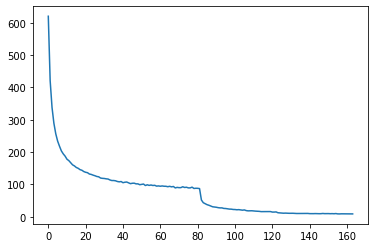

In [46]:
plt.plot(losses)

In [47]:
net.eval()
test_correct = 0.0
test_total = 0.0
for batch_idx, (x, y) in enumerate(cifar_loader['test']):
    x, y = x.to(device), y.to(device)
    out = net(x)
    test_correct += (out.argmax(1) == y).float().sum().item()
    test_total += x.size(0)
    
print(test_correct/test_total * 100.)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


91.55


Train CNNs wihtout residual connection. 

In [48]:
start_time = time.time()

net_plain = cnn18().to(device)
optimizer = torch.optim.SGD(net_plain.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
decay_epoch = [32000, 48000]
step_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epoch, gamma=0.1)

net_plain.train()

step = 0
epochs = 0
losses_plain = []

while step < 64000:

    train_loss = 0.0
    correct = 0.0
    total = 0.0

    for batch_idx, (x, y) in enumerate(cifar_loader['train']):
        step += 1
        step_lr_scheduler.step()
        x, y = x.to(device), y.to(device)
        out = net_plain(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).float().sum().item()
        total += x.size(0)
        train_loss += loss.item()

    losses_plain.append(train_loss)
    epochs += 1
    
    print("Epoch[{:d} ({:d}/64000) ({:.4f}sec)] loss: {:.2f} acc: {:.2f}".format(epochs, step, time.time()-start_time, train_loss, 100.*correct/total))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWa

Epoch[1 (391/64000) (39.7580sec)] loss: 684.85 acc: 32.93
Epoch[2 (782/64000) (79.6973sec)] loss: 520.92 acc: 51.39
Epoch[3 (1173/64000) (119.5475sec)] loss: 400.18 acc: 63.67
Epoch[4 (1564/64000) (159.4343sec)] loss: 334.46 acc: 70.07
Epoch[5 (1955/64000) (199.2413sec)] loss: 295.93 acc: 73.62
Epoch[6 (2346/64000) (239.1653sec)] loss: 273.18 acc: 75.85
Epoch[7 (2737/64000) (279.0850sec)] loss: 254.14 acc: 77.45
Epoch[8 (3128/64000) (319.0693sec)] loss: 240.67 acc: 78.81
Epoch[9 (3519/64000) (358.9402sec)] loss: 229.45 acc: 79.84
Epoch[10 (3910/64000) (398.8273sec)] loss: 219.64 acc: 80.61
Epoch[11 (4301/64000) (438.6453sec)] loss: 209.75 acc: 81.57
Epoch[12 (4692/64000) (478.6132sec)] loss: 202.35 acc: 82.09
Epoch[13 (5083/64000) (518.4061sec)] loss: 195.76 acc: 82.59
Epoch[14 (5474/64000) (558.4139sec)] loss: 192.40 acc: 82.90
Epoch[15 (5865/64000) (598.3334sec)] loss: 188.00 acc: 83.41
Epoch[16 (6256/64000) (638.2603sec)] loss: 181.83 acc: 83.87
Epoch[17 (6647/64000) (678.1493sec)] 

Plot train loss and calculate test performance.

In [ ]:
plt.plot(losses, label='resnet')
plt.plot(losses_plain, label='cnn')

In [ ]:
net_plain.eval()
test_correct = 0.0
test_total = 0.0
for batch_idx, (x, y) in enumerate(cifar_loader['test']):
    x, y = x.to(device), y.to(device)
    out = net_plain(x)
    test_correct += (out.argmax(1) == y).float().sum().item()
    test_total += x.size(0)
    
print(test_correct/test_total * 100.)


### Reference
* https://tutorials.pytorch.kr/beginner/blitz/neural_networks_tutorial.html
* https://github.com/dnddnjs/pytorch-cifar10/blob/enas/resnet/model.py
* https://icml.cc/2016/tutorials/icml2016_tutorial_deep_residual_networks_kaiminghe.pdf